In [1]:
%matplotlib inline

In [2]:
# Imports
import numpy as np 
import pandas as pd 
import warnings 
from glob import glob 
from skimage.io import imread
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.applications.xception import Xception
from keras.applications import VGG16
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,Conv2D
from keras.models import Model
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.optimizers import Adam
from livelossplot import PlotLossesKeras


In [3]:
warnings.filterwarnings('ignore')
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
TRAINING_RATIO = 0.0001

In [4]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory(
            'data/training',
            target_size = IMAGE_SIZE,
            class_mode = 'categorical',
            batch_size = 32)

test_set = test_datagen.flow_from_directory(
            'data/validation',
            target_size = IMAGE_SIZE,
            class_mode = 'categorical',
            batch_size = 32)
classes = {v: k for k, v in training_set.class_indices.items()}
classes

Found 1659 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


{0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}

In [5]:
#Model
input_shape = INPUT_SHAPE
inputs = Input(input_shape)
input_tensor = Input(shape= (224,224,3))
xception = Xception(include_top=False, input_shape = input_shape)(inputs)
nas_net = NASNetMobile(input_tensor = input_tensor, include_top = False, weights = 'imagenet')(inputs)


outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(xception), GlobalAveragePooling2D()(nas_net)])
outputs = Dropout(0.5)(outputs)
outputs = Dense(1, activation='sigmoid')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 7, 7, 2048)   20861480    input_1[0][0]                    
__________________________________________________________________________________________________
NASNet (Functional)             (None, 7, 7, 1056)   4269716     input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           xception[0][0]                   
_______________________________________________________________________________________

In [6]:
#  Training
history = model.fit_generator(training_set,
                              steps_per_epoch=30,
                              epochs=10,
                              validation_data=test_set)

model.save("LastModel.h5")
model.save_weights("LastModelWeights.h5") 


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
30/30 [==============================] - 987s 33s/step - loss: 0.5417 - accuracy: 0.7749 - val_loss: 0.7321 - val_accuracy: 0.4356
Epoch 2/5
30/30 [==============================] - 958s 32s/step - loss: 0.5132 - accuracy: 0.8000 - val_loss: 0.7963 - val_accuracy: 0.3625
Epoch 3/5
30/30 [==============================] - 969s 32s/step - loss: 0.5093 - accuracy: 0.8000 - val_loss: 0.7550 - val_accuracy: 0.4618
Epoch 4/5
30/30 [==============================] - 994s 33s/step - loss: 0.5081 - accuracy: 0.8000 - val_loss: 0.7377 - val_accuracy: 0.4280
Epoch 5/5
30/30 [==============================] - 891s 30s/step - loss: 0.5060 - accuracy: 0.8000 - val_loss: 0.7507 - val_accuracy: 0.3822


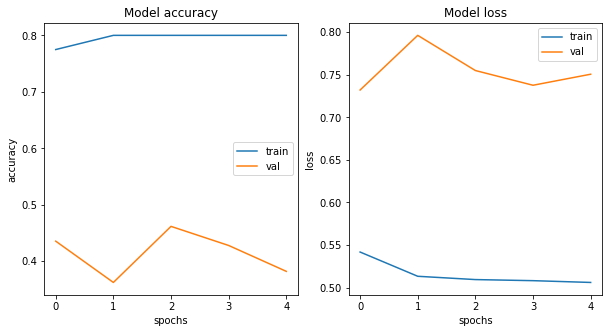

In [21]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax = ax.ravel()
for i, met in enumerate(['accuracy','loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('spochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
plt.show()